# Goal

Run on Docker

In [1]:
# Dataloader params

subset_size = 330

test_pct  = 1 - float(subset_size)/335
bs        = 2
nepochs   = 50
num_workers = 1

iso       = 3
maxs      = [87, 90, 90]

In [24]:
# PATHS

# CODE (DeepPit, OBELISK, etc)
code_src     = "/workspace"
deepPit_src  = f"{code_src}/DeepPit"
obelisk_src  = f"{code_src}/OBELISK"

# DATA (training, ABIDE, etc)
todd_data_src = "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"
olab_data_src = "/gpfs/data/oermannlab/private_data/DeepPit/"
docker_data_src = "../PitMRdata/Labels/ABIDE"

curr_data_src = docker_data_src

def change_src(fn, old_prefix=docker_data_src, new_prefix=olab_data_src):
    return new_prefix + fn[len(old_prefix):]

# path to training data
train_src = curr_data_src

# Imports

In [25]:
# imports
from transforms import AddChannel, Iso, PadSz

# Utilities
import os
import time
import pickle
from pathlib import Path

# Fastai
from fastai import *
from fastai.torch_basics import *
from fastai.basics import *

# PyTorch
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

# 3D extension to FastAI
# from faimed3d.all import *

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Helper functions
from helpers.preprocess import get_data_dict, paths2objs, folder2objs, seg2mask, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general import sitk2np, np2sitk, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups
from helpers.viz import viz_axis

import sys
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils import *

# Distributed Training

In [26]:
from fastai.distributed import *
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument("--local_rank", type=int)
# args = parser.parse_args()
# torch.cuda.set_device(args.local_rank)
# torch.distributed.init_process_group(backend='nccl', init_method='env://')

# Data

1. Source = path to labels (segmentation)
2. data dict[foldername] = (path to MR, path to Segm tensor)
    
Special subsets:
1. *training*: small subset of all labelled items (quick epoch w/ 100 instead of 335 items).
2. *unique*: subset of items with unique size, spacing, and orientation (quickly evaluate resize vs. istropic)

In [5]:
import time
model_time = time.ctime() # 'Mon Oct 18 13:35:29 2010'
print(f"Time: {model_time}")

Time: Fri Jun 18 16:35:29 2021


In [28]:
# labelled train data
train_src = docker_data_src

# print
print("Folders in train path: ", end=""); print(*os.listdir(train_src), sep=", ")

# get data
data = {}
folders = os.listdir(train_src)

# filter .zip
folders = [folder for folder in folders if not folder.endswith(".zip")]
print("Folders ", folders)

for folder in folders: data.update(get_data_dict(f"{train_src}/{folder}/{folder}"))

# all items
items = list(data.values())

# MR files: unique sz, sp, dir
with open(f'{deepPit_src}/saved_metadata/unique_sz_sp_dir.pkl', 'rb') as f:
    unique = pickle.load(f)

# Create (MR path, Segm path) item from MR path
def get_folder_name(s):
    start = s.index("samir_labels/")
    s = s[start + len("samir_labels/50373-50453/"):]
    return s[0:s.index("/")]

# get unique
unique = [(change_src(mr), data[get_folder_name(mr)][1]) for mr in unique]

# subset
subset_idxs, test_idxs = RandomSplitter(valid_pct=test_pct)(items)
subset = [items[i] for i in subset_idxs]
test   = [items[i] for i in test_idxs]

# print
print(f"Total {len(items)} items in dataset.")
print(f"Training subset of {len(subset)} items.")
print(f"Test subset of {len(test)} items.")

# model name
model_name = f"iso_{iso}mm_pad_{maxs[0]}_{maxs[1]}_{maxs[2]}_bs_{bs}_subset_{len(subset)}_epochs_{nepochs}_time_{model_time}"
print(f"Model name: {model_name}")

# save test set indices
with open(f'{deepPit_src}/model_test_sets/{model_name}_test_items.pkl', 'wb') as f:
    pickle.dump(list(test), f)
    
# print
print(f"Total {len(items)} items in dataset.")
print(f"Training subset of {len(subset)} items.")
print(f"Unique subset of {len(unique)} items.")

Folders in train path: 50213-50312.zip, 50373-50453, 50313-50372, 50155-50212.zip, 50213-50312, 50155-50212, 50313-50372.zip, 50373-50453.zip, 50002-50153, 50002-50153.zip
Folders  ['50373-50453', '50313-50372', '50213-50312', '50155-50212', '50002-50153']
Total 335 items in dataset.
Training subset of 330 items.
Test subset of 5 items.
Model name: iso_3mm_pad_87_90_90_bs_2_subset_330_epochs_50_time_Fri Jun 18 16:35:29 2021
Total 335 items in dataset.
Training subset of 330 items.
Unique subset of 28 items.


In [30]:
# model name
model_name = f"iso_3mm_pad_87_90_90_bs_{bs}_subset_{len(subset)}_epochs_{nepochs}_time_{model_time}"
print(f"Model name: {model_name}"),

# save test set indices\n",
with open(f'{deepPit_src}/model_test_sets/{model_name}_test_items.pkl', 'wb') as f:
    pickle.dump(list(test), f)
      
# with open(f"model_test_sets/{model_name}_test_items.pkl", 'rb') as f:
#     test = pickle.load(f)
# print(test[0]), print(len(test))

Model name: iso_3mm_pad_87_90_90_bs_2_subset_330_epochs_50_time_Fri Jun 18 16:35:29 2021


# Transforms

1. Isotropic 3mm or Resize to 50x50x50 dimensions
2. Crop/Pad to common dimensions

In [31]:
# # test

# tfms = [Iso(3)]
# tls = TfmdLists(unique, tfms)

# start = time.time()
# iso_szs = [mr.shape for mr,mk in tls]
# elapsed = time.time() - start

# print(f"Elapsed: {elapsed} s for {len(unique)} items.")

In [32]:
# start = time.time()
# iso_szs = [mr.shape for mr,mk in tls]
# elapsed = time.time() - start

# print(f"Elapsed: {elapsed} s for {len(unique)} items.")

In [33]:
# print(*[f"{get_folder_name(mr)}: {tuple(sz)}" for (mr,mk),sz in zip(unique, iso_szs)], sep="\n")

In [34]:
# maxs = [int(x) for x in torch.max(torch.tensor(iso_szs), dim=0).values]
# print("Maxs: ", maxs)

# Crop

In [35]:
# # test
# iso_items = list(tls[0:2])

# # tfms
# pad_tfms = [PadSz(maxs)]

# # tls
# pad_tls = TfmdLists(iso_items, pad_tfms)

# pad_tls[0][0].shape, pad_tls[1][0].shape

# Dataloaders

TODO augmentations.

- dset = tfms applied to items
- splits into training/valid
- bs

In [37]:
# time it
start = time.time()

# splits
splits = RandomSplitter(seed=42)(subset)
print(f"Training: {len(splits[0])}, Valid: {len(splits[1])}")

# tfms
tfms = [Iso(3), PadSz(maxs)]

# tls
tls = TfmdLists(items, tfms, splits=splits)

# dls
dls = tls.dataloaders(bs=bs, after_batch=AddChannel(), num_workers=num_workers)

# GPU
dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(subset)} items")

# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(len(dls.train), len(dls.valid))

Training: 264, Valid: 66
Elapsed time: 2.158508539199829 s for 330 items
<class 'tuple'> torch.Size([2, 1, 87, 90, 90]) torch.Size([2, 1, 87, 90, 90])
132 33


# Metric

Linear combination of Dice and Cross Entropy

In [38]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

## OBELISK

In [39]:
# start = time.time()

# segs = torch.cat([tl[1] for tl in dls.train],0)
# print(segs.shape)

# elapsed = time.time() - start

# print(f"Elapsed time: {elapsed} s for {len(segs)} items")

In [40]:
# class_weight = torch.sqrt(1.0/(torch.bincount(segs.view(-1)).float()))
# class_weight = class_weight/class_weight.mean()
# class_weight[0] = 0.5
# np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
# print('inv sqrt class_weight',class_weight.data.cpu().numpy())

In [41]:
from utils import my_ohem

In [42]:
# pos_weight = torch.load("saved_metadata/class_weights.pt")
# class_weights = [0, pos_weight]

# # inv
# class_weights [1.0/x for x in class_wei]
# my_criterion = my_ohem(.25,[0, pos_weight]) #.cuda())#0.25 

In [43]:
def obelisk_loss_fn(predict, target): return my_criterion(F.log_softmax(predict,dim=1),target)

In [44]:
# ipython nbconvert --to python  '6 - Dataloaders- NB - Simple-Copy1.ipynb'

# Learner

In [45]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [46]:
# OBELISK-NET from github
from models import obelisk_visceral, obeliskhybrid_visceral

In [48]:
full_res = maxs

learn = Learner(dls=dls, \
                model=obeliskhybrid_visceral(num_labels=2, full_res=full_res), \
                loss_func= loss, #DiceLoss(), #nn.CrossEntropyLoss(), \
                metrics = dice_score, \
                model_dir = code_src + "models", \
                cbs = [SaveModelCallback(monitor='dice_score', fname=model_name, with_opt=True)])

# SaveModelCallback: model_dir = "./models", cbs = [SaveModelCallback(monitor='dice_score')]

# GPU
learn.model = learn.model.cuda()

#learn = learn.to_distributed(args.local_rank)


In [49]:
# # test:

# #dls.device = "cpu"

# start = time.time()

# x,y = dls.one_batch()
# #x,y = to_cpu(x), to_cpu(y)

# pred = learn.model(x)
# loss = learn.loss_func(pred, y)

# elapsed = time.time() - start

# print(f"Elapsed: {elapsed} s")
# print("Batch: x,y")
# print(type(x), x.shape, x.dtype, "\n", type(y), y.shape, y.dtype)

# print("Pred shape")
# print(type(pred), pred.shape, pred.dtype)

# print("Loss")
# print(loss)
# print(learn.loss_func)

# LR Finder

In [50]:
# learn.lr_find()

In [82]:
print("PRE learn.fit one cycle")
with learn.distrib_ctx():
    learn.fit_one_cycle(1, 3e-3, wd = 1e-4)

PRE learn.fit one cycle


epoch,train_loss,valid_loss,dice_score,time
0,1.017327,0.955622,0.560371,01:39


Better model found at epoch 0 with dice_score value: 0.5603711605072021.


In [51]:
print("unfreeze, learn 50")
learn.unfreeze()
with learn.distrib_ctx():
    learn.fit_one_cycle(nepochs, 3e-3, wd = 1e-4)

unfreeze, learn 50


epoch,train_loss,valid_loss,dice_score,time
0,1.508293,1.419596,0.023283,00:25
1,1.305650,1.198959,0.119322,00:25
2,1.122148,1.058931,0.327266,00:25
3,0.969378,0.928443,0.681038,00:24
4,0.468230,0.376098,0.673380,00:25
5,0.285837,0.227961,0.793906,00:24
6,0.245115,0.343518,0.678921,00:25
7,0.232375,0.271501,0.736131,00:24
8,0.237001,0.241869,0.780092,00:23
9,0.210405,0.333116,0.671908,00:23


Better model found at epoch 0 with dice_score value: 0.02328326366841793.
Better model found at epoch 1 with dice_score value: 0.11932217329740524.
Better model found at epoch 2 with dice_score value: 0.32726627588272095.
Better model found at epoch 3 with dice_score value: 0.6810376048088074.
Better model found at epoch 5 with dice_score value: 0.7939056754112244.
Better model found at epoch 10 with dice_score value: 0.8062425255775452.
Better model found at epoch 12 with dice_score value: 0.817424476146698.
Better model found at epoch 14 with dice_score value: 0.8198553919792175.
Better model found at epoch 20 with dice_score value: 0.8205769062042236.
Better model found at epoch 21 with dice_score value: 0.8231424689292908.


KeyboardInterrupt: 

In [86]:
# learn.save('iso_3mm_pad_87_90_90_subset_50_epochs_50')

Path('models/iso_3mm_pad_87_90_90_subset_50_epochs_50.pth')

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.309573450380412e-07)

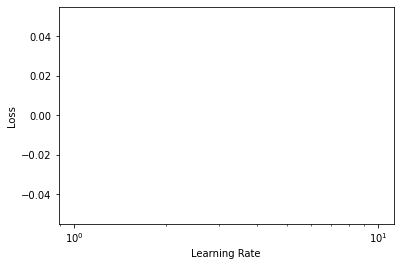

In [72]:
# learn.lr_find()

In [ ]:
# print("unfreeze, learn 50")
# learn.unfreeze()
# learn.fit_one_cycle(50, 1e-3, wd = 1e-4)

In [137]:
# testmask = torch.tensor([[[False, False, False], [False, False, False], [True, True, True]],
#                        [[False, False, False], [False, False, True], [True, True, True]],
#                        [[False, False, False], [False, False, False], [False, False, False]]])
# testmask

In [138]:
# testmaskN = np.array(testmask)
# testmaskN

In [139]:
# maskT = testmask.type(torch.BoolTensor)

# iT = torch.any(maskT, dim=(1,2))
# jT = torch.any(maskT, dim=(0,2))
# kT = torch.any(maskT, dim=(0,1))

# iminT, imaxT = torch.where(iT)[0][[0, -1]]
# jminT, jmaxT = torch.where(jT)[0][[0, -1]]
# kminT, kmaxT = torch.where(kT)[0][[0, -1]]

In [140]:
# maskN = np.array(testmask).astype(bool)
    
# iN = np.any(maskN, axis=(1, 2))
# jN = np.any(maskN, axis=(0, 2))
# kN = np.any(maskN, axis=(0, 1))

# iminN, imaxN = np.where(iN)[0][[0, -1]]
# jminN, jmaxN = np.where(jN)[0][[0, -1]]
# kminN, kmaxN = np.where(kN)[0][[0, -1]]

In [141]:
# maskT.shape, maskN.shape

In [142]:
# print(iT)
# print(jT)
# print(kT)
# print([x for x in (iminT, imaxT, jminT, jmaxT, kminT, kmaxT)])

In [143]:
# print(iN)
# print(jN)
# print(kN)
# print([int(x) for x in (iminN, imaxN, jminN, jmaxN, kminN, kmaxN)])

In [ ]:
#     def torch_mask2bbox(mask):
#         mask = mask.type(torch.BoolTensor)

#         i = torch.any(mask, dim=0)
#         j = torch.any(mask, dim=1)
#         k = torch.any(mask, dim=2)

#         imin, imax = torch.where(i)[0][[0, -1]]
#         jmin, jmax = torch.where(j)[0][[0, -1]]
#         kmin, kmax = torch.where(k)[0][[0, -1]]

#         # inclusive idxs
#         return imin, imax+1, jmin, jmax+1, kmin, kmax+1